In [1]:
import numpy as np
import netCDF4 as nc
import f90nml
import os
from salishsea_tools import bio_tools as bio
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# load necessary files
resDir='/results/SalishSea/nowcast-green/28aug17'
nampisprod=bio.load_nml_bio(resDir,'nampisprod')
fdia=nc.Dataset(os.path.join(resDir,'SalishSea_2h_20170828_20170828_dia1_T.nc'))
fptc=nc.Dataset(os.path.join(resDir,'SalishSea_1h_20170828_20170828_ptrc_T.nc'))
m=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
tmask=m.variables['tmask'][:,:,:,:]
m.close()

In [3]:
# times 9, 19 are around noon local time
I=fdia.variables['PAR'][9,:,:,300]
NO=fptc.variables['nitrate'][19,:,:,300]
NH=fptc.variables['ammonium'][19,:,:,300]
Si=fptc.variables['silicon'][19,:,:,300]

In [4]:
D,M,N = bio.calc_p_limiters(I,NO,NH,Si,tmask[0,:,:,300],nampisprod)

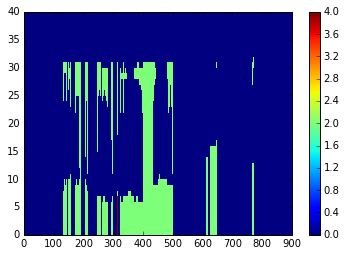

In [5]:
a=plt.pcolormesh(D['limiter'])
plt.colorbar(a)

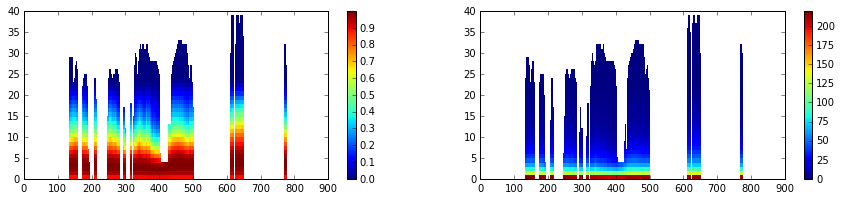

In [6]:
fig,ax=plt.subplots(1,2,figsize=(15,3))
a=ax[0].pcolormesh(np.ma.masked_where(tmask[0,:,:,300]==0,D['ILim']))
p=fig.colorbar(a,ax=ax[0])
a2=ax[1].pcolormesh(np.ma.masked_where(tmask[0,:,:,300]==0,I))
p2=fig.colorbar(a2,ax=ax[1])

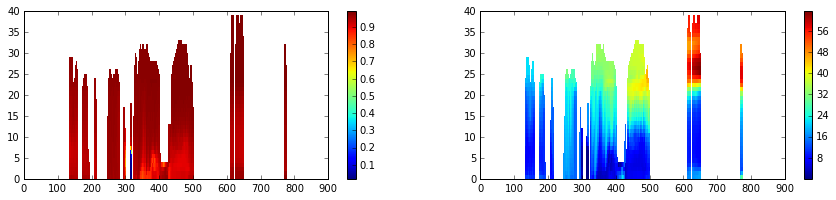

In [7]:
fig,ax=plt.subplots(1,2,figsize=(15,3))
a=ax[0].pcolormesh(np.ma.masked_where(tmask[0,:,:,300]==0,D['SiLim']))
p=fig.colorbar(a,ax=ax[0])
a2=ax[1].pcolormesh(np.ma.masked_where(tmask[0,:,:,300]==0,Si))
p2=fig.colorbar(a2,ax=ax[1])

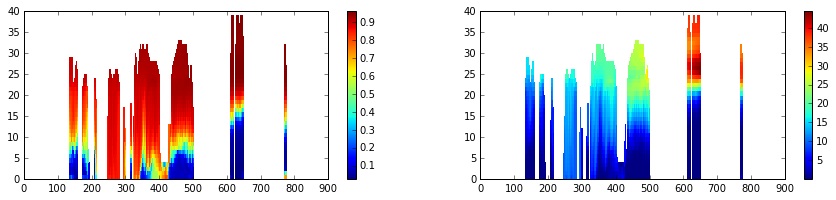

In [8]:
fig,ax=plt.subplots(1,2,figsize=(15,3))
a=ax[0].pcolormesh(np.ma.masked_where(tmask[0,:,:,300]==0,D['NLim']))
p=fig.colorbar(a,ax=ax[0])
a2=ax[1].pcolormesh(np.ma.masked_where(tmask[0,:,:,300]==0,NO))
p2=fig.colorbar(a2,ax=ax[1])

In [9]:
nampisprod

Namelist([('zz_rate_r_diat', 6e-05),
          ('zz_rate_r_myri', 2.5e-05),
          ('zz_rate_r_nano', 2.5e-05),
          ('zz_rate_maxtemp_diat', 35.0),
          ('zz_rate_maxtemp_myri', 35.0),
          ('zz_rate_maxtemp_nano', 35.0),
          ('zz_rate_temprange_diat', 5.0),
          ('zz_rate_temprange_myri', 5.0),
          ('zz_rate_temprange_nano', 5.0),
          ('zz_rate_iopt_diat', 42.0),
          ('zz_rate_iopt_myri', 37.0),
          ('zz_rate_iopt_nano', 10.0),
          ('zz_rate_gamma_diat', 0.0),
          ('zz_rate_gamma_myri', 0.0),
          ('zz_rate_gamma_nano', 0.0),
          ('zz_rate_k_si_diat', 0.6),
          ('zz_rate_k_si_myri', 0.0),
          ('zz_rate_k_si_nano', 0.0),
          ('zz_rate_gamma_o_diat', 0.0),
          ('zz_rate_gamma_o_myri', 0.0),
          ('zz_rate_gamma_o_nano', 0.0),
          ('zz_rate_kapa_diat', 1.0),
          ('zz_rate_kapa_myri', 0.5),
          ('zz_rate_kapa_nano', 0.3),
          ('zz_rate_k_diat', 2.0),
          

In [10]:
def each_limiter(zz_I_par,zz_NO,zz_NH,zz_Si,
                 zz_rate_Iopt,zz_rate_gamma,zz_rate_K_Si,zz_rate_kapa,zz_rate_k):
    # Light
    zz_plank_growth_light = (1.0 - np.exp(-zz_I_par / (0.33 * zz_rate_Iopt)) ) * \
                           (np.exp(-zz_I_par / (30. * zz_rate_Iopt))) * 1.06
    zz_Uc = (1.0 - zz_rate_gamma) * zz_plank_growth_light
    ILim=zz_Uc
    # Si
    zz_Sc = np.where(zz_Si>0.0,zz_Si / (zz_rate_K_Si + zz_Si),0.0)
    SiLim=zz_Sc
    # Nitrate and Ammonium
    zz_Oup_cell = np.where(zz_NO > 0.0, 
                zz_NO * zz_rate_kapa / (zz_rate_k + zz_NO * zz_rate_kapa + zz_NH),0.0)
    zz_Hup_cell = np.where(zz_NH > 0.0, 
                zz_NH / (zz_rate_k + zz_NO * zz_rate_kapa + zz_NH),0.0)
    if (np.any(zz_Oup_cell < 0.)):
        raise ValueError('zz_Oup_cell<0')
    if (np.any(zz_Hup_cell < 0.)):
        raise ValueError('zz_Hup_cell<0')
    NLim=zz_Oup_cell+zz_Hup_cell
    # set flags
    limiter=-1*np.ones(zz_Si.shape)
    limiter=np.where(np.logical_and(ILim<=NLim,ILim<=SiLim),0,
                     np.where(NLim<=SiLim,1,np.where(SiLim<NLim,2,limiter)))

    return ILim, NLim, SiLim, limiter


In [11]:
def calc_p_limiters(I,NO,NH,Si,nampisprod):
    ILimDiat, NLimDiat, SiLimDiat, limiterDiat=each_limiter(I,NO,NH,Si,nampisprod['zz_rate_Iopt_diat'],
                                        nampisprod['zz_rate_gamma_diat'],nampisprod['zz_rate_k_Si_diat'],
                                        nampisprod['zz_rate_kapa_diat'],nampisprod['zz_rate_k_diat'])
    
    ILimMyri, NLimMyri, SiLimMyri, limiterMyri=each_limiter(I,NO,NH,Si,nampisprod['zz_rate_Iopt_myri'],
                                        nampisprod['zz_rate_gamma_myri'],nampisprod['zz_rate_k_Si_myri'],
                                        nampisprod['zz_rate_kapa_myri'],nampisprod['zz_rate_k_myri'])
    
    ILimNano, NLimNano, SiLimNano, limiterNano=each_limiter(I,NO,NH,Si,nampisprod['zz_rate_Iopt_nano'],
                                        nampisprod['zz_rate_gamma_nano'],nampisprod['zz_rate_k_Si_nano'],
                                        nampisprod['zz_rate_kapa_nano'],nampisprod['zz_rate_k_nano'])
    Diat={'ILim':ILimDiat,'NLim':NLimDiat,'SiLim':SiLimDiat,'limiter':limiterDiat}
    Myri={'ILim':ILimMyri,'NLim':NLimMyri,'SiLim':SiLimMyri,'limiter':limiterMyri}
    Nano={'ILim':ILimNano,'NLim':NLimNano,'SiLim':SiLimNano,'limiter':limiterNano}
    return Diat, Myri, Nano

In [12]:
ILim, NLim, SiLim, limiter = each_limiter(np.array((1000,1000,500,500,500,100,100,0.0,0.0)),
                                          np.array((   0,20.0, 15, 0.,122,16.,0.0,23.,30.)),
                                          np.array((   0,  0.,122,16.,0.0,23.,30.,20 ,20.)),
                                          np.array((  60, 0.0, 25, 40,2.2,3.3,0.0,60.,40.)),
                    nampisprod['zz_rate_Iopt_diat'],nampisprod['zz_rate_gamma_diat'],
                    nampisprod['zz_rate_k_Si_diat'],nampisprod['zz_rate_kapa_diat'],nampisprod['zz_rate_k_diat'])

In [13]:
ILim, NLim, SiLim, limiter = each_limiter(np.array((1000,1000,500,500,500,100,100,0.0,0.0)),
                                          np.array((   0,20.0, 15, 0.,122,16.,0.0,23.,30.)),
                                          np.array((   0,  0.,122,16.,0.0,23.,30.,20 ,20.)),
                                          np.array((  60, 0.0, 25, 40,2.2,3.3,0.0,60.,40.)),
                    nampisprod['zz_rate_Iopt_myri'],nampisprod['zz_rate_gamma_myri'],
                    nampisprod['zz_rate_k_Si_myri'],nampisprod['zz_rate_kapa_myri'],nampisprod['zz_rate_k_myri'])

/home/eolson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


In [14]:
zz_Si=np.array((  60, 0.0, 25, 40,2.2,3.3,0.0,60.,40.))
zz_Sc = np.where(zz_Si>0.0,zz_Si / (0 + zz_Si),0.0)

/home/eolson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [15]:
print(nampisprod['zz_rate_Iopt_myri'],nampisprod['zz_rate_gamma_myri'],
                    nampisprod['zz_rate_k_Si_myri'],nampisprod['zz_rate_kapa_myri'],nampisprod['zz_rate_k_myri'])

37.0 0.0 0.0 0.5 0.5


In [16]:
D,M,N = calc_p_limiters(np.array((1000,1000,500,500,500,100,100,0.0,0.0)),
                                np.array((   0,20.0, 15, 0.,122,16.,0.0,23.,30.)),
                                np.array((   0,  0.,122,16.,0.0,23.,30.,20 ,20.)),
                                np.array((  60, 0.0, 25, 40,2.2,3.3,0.0,60.,40.)),nampisprod)

/home/eolson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


In [17]:
NLim

array([ 0.        ,  0.95238095,  0.99615385,  0.96969697,  0.99186992,
        0.98412698,  0.98360656,  0.984375  ,  0.98591549])

In [18]:
SiLim

array([ 1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.])

In [19]:
limiter

array([ 1.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.])

In [20]:
ILim=np.array(((np.nan,0.0,0.0,0.0),(0.5,0.5,0.5,0.5),(1.0,1.0,1.0,1.0)))

In [21]:
NLim=np.array(((np.nan,0.0,0.5,1.0),(0.0,0.0,0.5,0.5),(0.0,0.5,0.2,0.0)))

In [22]:
SiLim=np.array(((np.nan,0.0,1.0,0.5),(1.0,0.2,0.0,1.0),(0.5,0.0,0.3,0.0)))

In [23]:
SiLim

array([[ nan,  0. ,  1. ,  0.5],
       [ 1. ,  0.2,  0. ,  1. ],
       [ 0.5,  0. ,  0.3,  0. ]])

In [24]:
limiter=-1*np.ones(ILim.shape)
limiter

array([[-1., -1., -1., -1.],
       [-1., -1., -1., -1.],
       [-1., -1., -1., -1.]])

In [25]:

limiter=np.where(np.logical_and(ILim<=NLim,ILim<=SiLim),0,np.where(NLim<=SiLim,1,np.where(SiLim<NLim,2,limiter)))

/home/eolson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/home/eolson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [26]:
print(ILim)
print(NLim)
print(SiLim)

[[ nan  0.   0.   0. ]
 [ 0.5  0.5  0.5  0.5]
 [ 1.   1.   1.   1. ]]
[[ nan  0.   0.5  1. ]
 [ 0.   0.   0.5  0.5]
 [ 0.   0.5  0.2  0. ]]
[[ nan  0.   1.   0.5]
 [ 1.   0.2  0.   1. ]
 [ 0.5  0.   0.3  0. ]]


In [27]:
print(limiter)

[[-1.  0.  0.  0.]
 [ 1.  1.  2.  0.]
 [ 1.  2.  1.  1.]]


In [28]:
test={'a':1,'b':2}

In [29]:
test

{'a': 1, 'b': 2}

In [30]:
test['a']

1